In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from folium import plugins
%matplotlib inline

sns.set()
plt.rcParams["figure.figsize"] = (15,7)

In [2]:
!ls ./datasets

Speed_Camera_Violations.csv


In [3]:
violations_df = pd.read_csv("./datasets/Speed_Camera_Violations.csv")

In [4]:
violations_df.head()

,ADDRESS,CAMERA ID,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,7738 S WESTERN,CHI065,07/08/2014,65,NaN,NaN,NaN,NaN,NaN
1,1111 N HUMBOLDT,CHI010,07/16/2014,56,NaN,NaN,NaN,NaN,NaN
2,5520 S WESTERN,CHI069,07/08/2014,10,NaN,NaN,NaN,NaN,NaN
3,1111 N HUMBOLDT,CHI010,07/26/2014,101,NaN,NaN,NaN,NaN,NaN
4,1111 N HUMBOLDT,CHI010,07/27/2014,92,NaN,NaN,NaN,NaN,NaN


In [5]:
#The mean number of violations per camera per day is 28.88
violations_df.describe()

,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE
count,170521.000000,1.639590e+05,1.639590e+05,163959.000000,163959.000000
mean,28.880449,1.159712e+06,1.893473e+06,41.863389,-87.689229
std,36.636151,1.570560e+04,3.212393e+04,0.088338,0.057135
min,1.000000,1.121638e+06,1.820629e+06,41.663174,-87.828317
25%,7.000000,1.149783e+06,1.868078e+06,41.793493,-87.725084
50%,16.000000,1.159169e+06,1.898488e+06,41.877243,-87.689803
75%,37.000000,1.167170e+06,1.920991e+06,41.939040,-87.662810
max,479.000000,1.203645e+06,1.943342e+06,42.000260,-87.529848


In [6]:
violations_df.columns=["ADDRESS", "CAMERA_ID", "VIOLATION_DATE", "VIOLATIONS", "X_COORDINATE", "Y_COORDINATE",
                                    "LATITUDE", "LONGITUDE", "LOCATION"]

Text(0.5, 1.0, 'Number of Traffic Violations per Camera, per Day ')

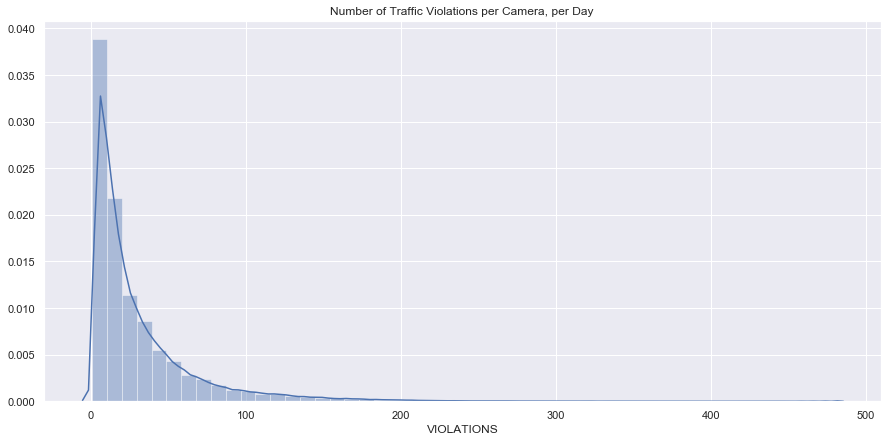

In [7]:
# The mean number of violations per camera per day is 29, however, there is a huge variance 
# This chart doesn't allow us to tell if this variation is due to time or camera location
plt.rcParams["figure.figsize"] = (15,7)
sns.distplot(violations_df["VIOLATIONS"]).set_title("Number of Traffic Violations per Camera, per Day ")

Text(0.5, 1.0, 'Total Traffic Violations per Day')

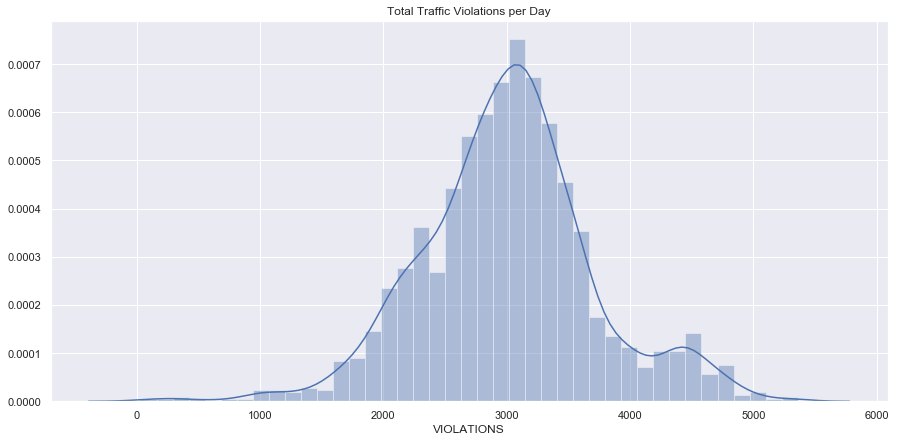

In [8]:
# The total number of traffic violations per day seems to be more normally distributed
# Camera location therefor accounts for most of the positive skew in the chart above.
grouped_by_dates = violations_df.groupby(["VIOLATION_DATE"])
sns.distplot(grouped_by_dates.sum()["VIOLATIONS"]).set_title("Total Traffic Violations per Day")

In [9]:
#Most violations are issued on a Friday
days_of_the_week = {
    0:"Monday",
    1:"Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

violations_df.columns = ["ADDRESS", "CAMERA_ID", "VIOLATION_DATE", "VIOLATIONS", "X_COORDINATE", 
                         "Y_COORDINATE", "LATITUDE", "LONGITUDE", "LOCATION"]

sum_of_violations_per_day = grouped_by_dates.sum().reset_index()
sum_of_violations_per_day["VIOLATION_DATE"] = pd.to_datetime(sum_of_violations_per_day["VIOLATION_DATE"])
sum_of_violations_per_day["WEEKDAY"] = sum_of_violations_per_day["VIOLATION_DATE"].apply(lambda x: x.weekday())
total_violations_per_weekday = sum_of_violations_per_day.groupby(["WEEKDAY"]).sum()
total_violations_per_weekday = total_violations_per_weekday.reset_index()[["WEEKDAY", "VIOLATIONS"]]
total_violations_per_weekday["WEEKDAY"] = total_violations_per_weekday["WEEKDAY"].map(days_of_the_week)
total_violations_per_weekday = total_violations_per_weekday.set_index("WEEKDAY")
total_violations_per_weekday

,VIOLATIONS
WEEKDAY,
Monday,686724
Tuesday,708276
Wednesday,705136
Thursday,730603
Friday,753468
Saturday,676715
Sunday,663801


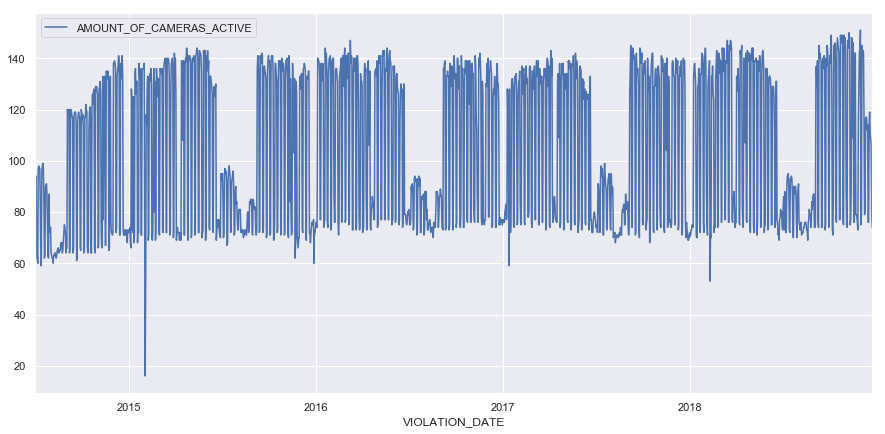

In [10]:
#There is quite some fluctuation of the total active cameras per day
amount_of_cameras = grouped_by_dates.nunique().reset_index()[["VIOLATION_DATE", "CAMERA_ID"]]
amount_of_cameras["VIOLATION_DATE"] = pd.to_datetime(amount_of_cameras["VIOLATION_DATE"])
amount_of_cameras = amount_of_cameras.set_index("VIOLATION_DATE").sort_index()
amount_of_cameras.columns = ["AMOUNT_OF_CAMERAS_ACTIVE"]
amount_of_cameras.plot()

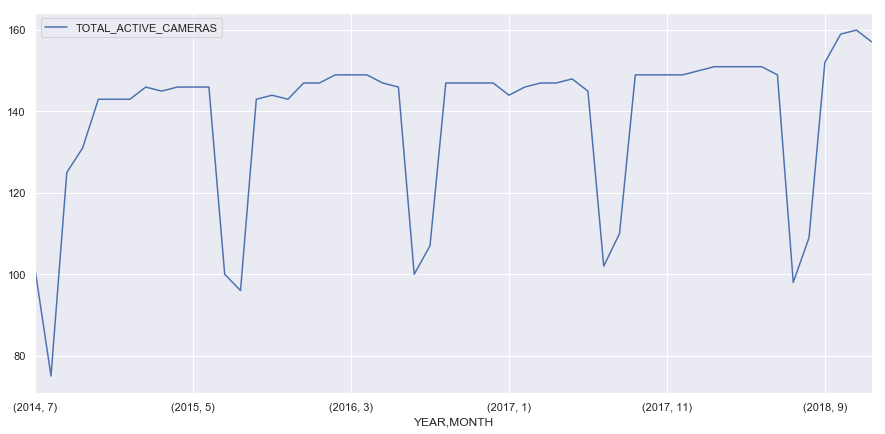

In [11]:
#If we plot the total active cameras per month, the chart is a lot cleaner
# Even though there is much variation during the year, the total amount of Cameras increased from (we assume)
#  a peek of 143 in 2014 to a peak of 160 in 2018.
violations_2df = violations_df
violations_2df["VIOLATION_DATE"] = pd.to_datetime(violations_df["VIOLATION_DATE"])
violations_2df = violations_df.set_index("VIOLATION_DATE").sort_index()
grouped_by_months_and_years = violations_2df.groupby(by = [violations_2df.index.year, violations_2df.index.month])
amount_of_cameras_per_month = grouped_by_months_and_years.nunique()[["CAMERA_ID"]]
amount_of_cameras_per_month.columns = ["TOTAL_ACTIVE_CAMERAS"]
amount_of_cameras_per_month = amount_of_cameras_per_month.rename_axis(["YEAR", "MONTH"])
amount_of_cameras_per_month.plot();

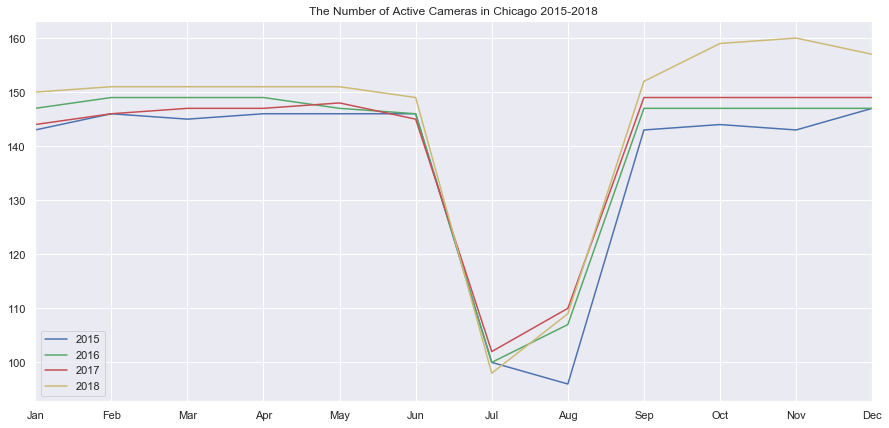

In [12]:
##This conclusion is even more apparent in the chart below
# Plotting the years 2015, 2016, 2017, and 2018, we see a steady annual increase in the 
# number of active cameras. There is a huge spike in September and October of 2018.
# We see also see a recurring ~30% dip in camera activity during July and August.
# The city officials seem to be turning some cameras off during those months.

months = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split(" ")

ax = amount_of_cameras_per_month[6:18].plot(use_index=False)
amount_of_cameras_per_month[18:30].plot(ax=ax,style='g', use_index=False)
amount_of_cameras_per_month[30:42].plot(ax=ax, style='r', use_index=False)
amount_of_cameras_per_month[42:54].plot(ax=ax, style="y", use_index=False)
ax.set_xticklabels(months)
ax.set_xticks(range(len(months)))
ax.set_title("The Number of Active Cameras in Chicago 2015-2018")
ax.legend(["2015", "2016", "2017", "2018"]);

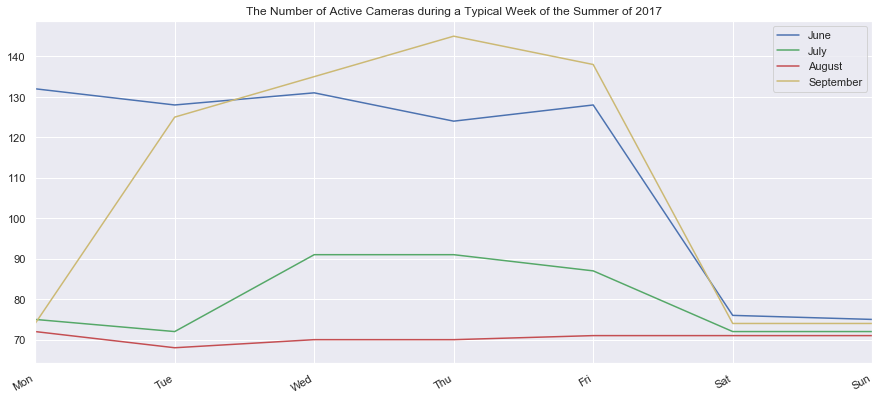

In [13]:
# Many cameras are also turned off on Saturday and Sundays.
# In early July, many of the cameras that are usually turned off on the weekends seem to have stayed off
# I would have a closer look more to check whether these are the same cameras.
days_of_the_week_lab = "Mon Tue Wed Thu Fri Sat Sun".split(" ")

grouped_by_days = violations_2df.groupby(by = [violations_2df.index]).nunique()
amount_of_cameras_by_day = grouped_by_days[["CAMERA_ID"]].reset_index()
amount_of_cameras_by_day["VIOLATION_DATE"] = pd.to_datetime(amount_of_cameras_by_day["VIOLATION_DATE"])
amount_of_cameras_by_day = amount_of_cameras_by_day.set_index("VIOLATION_DATE").sort_index()

ax = amount_of_cameras_by_day[1070:1077].plot(use_index=False) #First Full Week of June 2017
amount_of_cameras_by_day[1098:1105].plot(ax=ax, style="g", use_index=False) #First Full Week of July 2017
amount_of_cameras_by_day[1133:1140].plot(ax=ax, style="r", use_index=False) #First Full Week of August 2017
amount_of_cameras_by_day[1161:1168].plot(ax=ax, style="y", use_index=False) #First Full Week of September 2017

ax.set_xticklabels(days_of_the_week_lab)
ax.set_xticks(range(len(days_of_the_week_lab)))
ax.set_title("The Number of Active Cameras during a Typical Week of the Summer of 2017")
ax.legend(["June", "July", "August", "September"])

In [14]:
# I've created a simple Heatmap of the distribution of traffic Cameras around the city of Chicago
# This heatmap is not representative of the number of violations taking place.
m = folium.Map([41.8781, -87.6298], zoom_start=10.5)

violations_df_without_na = violations_df.dropna()
violations_grouped_by_camera = violations_df_without_na.groupby(["CAMERA_ID"]).mean().reset_index()

for index, row in violations_grouped_by_camera.iterrows():
    folium.CircleMarker([row['LATITUDE'], row['LONGITUDE']],
                       radius=5,
                       popup=row['CAMERA_ID'],
                       fill_color="#3db7e4").add_to(m)
    
violationArr = violations_grouped_by_camera[["LATITUDE", "LONGITUDE"]].as_matrix()

m.add_child(plugins.HeatMap(violationArr, radius=30))
m

/Users/lucasastorian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [15]:
# I need to create a new dataframe in order to make a heatmap of the violations.
# In the heatmap_df, each entry corresponds to one violation for an arbtrary day in October, 2016

some_traffic_violations = violations_df_without_na.loc[violations_df_without_na["VIOLATION_DATE"] == "2014-10-16"]
heatmap_data = []
heatmap_df = pd.DataFrame(columns=["LATITUDE", "LONGITUDE"])

for index, row in some_traffic_violations.iterrows():
    for i in range(row[3]):
        heatmap_data.append([row[6], row[7]])

heatmap_df = pd.DataFrame(heatmap_data, columns=["LATITUDE", "LONGITUDE"])

In [16]:
#I've plotted the traffic violations from October 16th 2014 below.
#Cameras in Roscoe Village and just east of the Illinois Medical district seem to 
# account for a good part of the traffic violations on that day
m = folium.Map([41.8781, -87.6298], zoom_start=11)
violationArr = heatmap_df[["LATITUDE", "LONGITUDE"]].as_matrix()
m.add_child(plugins.HeatMap(violationArr, radius=35))
m

/Users/lucasastorian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [17]:
#I really enjoyed this project and am looking forward to more like it. 
#Thank you for your consideration.